In [1]:
# Import essential libraries for data manipulation and visualization
import scanpy as sc  # For single-cell RNA-seq data
import anndata  # Annotated data matrix
import bbknn  # Batch-balanced KNN

# Seaborn and Matplotlib for visualization
import seaborn as sns
from matplotlib import cm
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context

/Users/pablodigiusto/miniforge3/envs/secrecon/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/pablodigiusto/miniforge3/envs/secrecon/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/pablodigiusto/miniforge3/envs/secrecon/lib/

In [2]:
# Load preprocessed datasets for three experiments
exp100=sc.read('exp100.h5',gex_only=False)
exp105=sc.read('exp105.h5',gex_only=False)
exp106=sc.read('exp106.h5',gex_only=False)

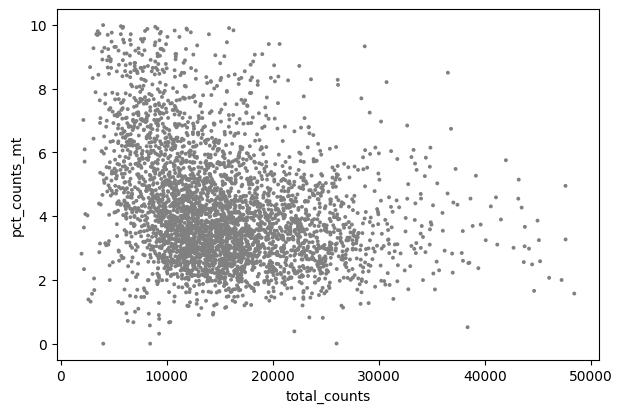

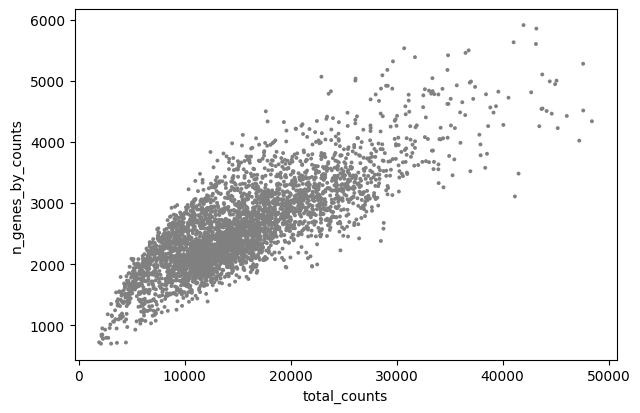

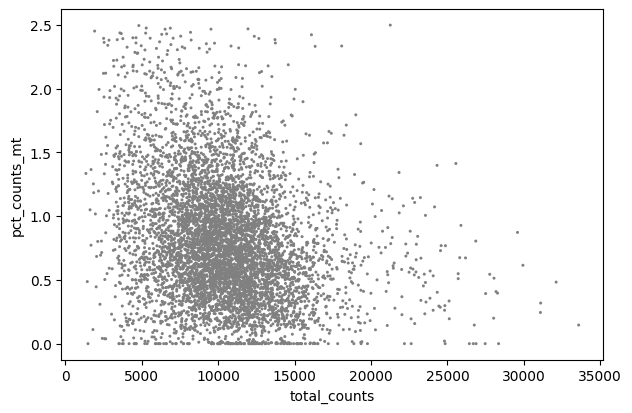

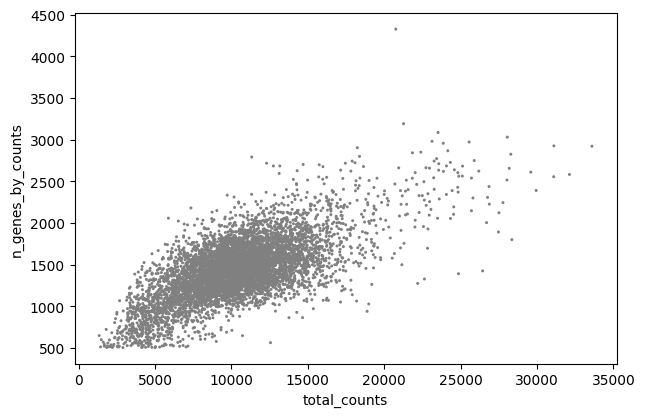

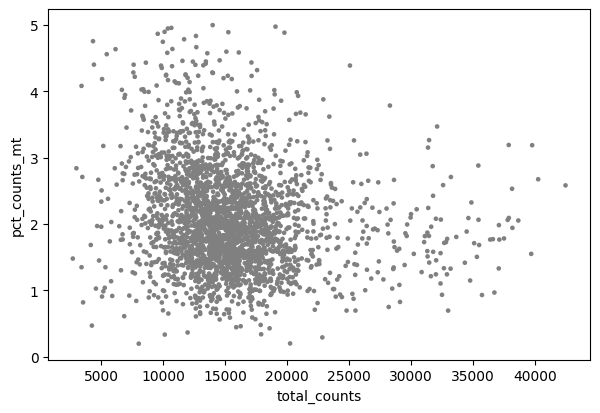

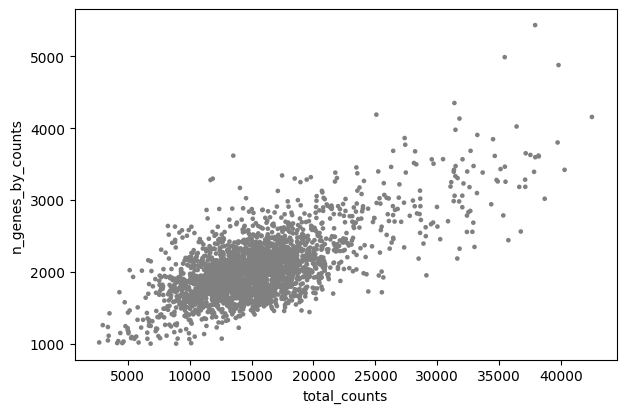

In [3]:
# Visualize QC metrics through scatter plots for each experiment
sc.pl.scatter(exp100, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(exp100, x='total_counts', y='n_genes_by_counts')
sc.pl.scatter(exp105, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(exp105, x='total_counts', y='n_genes_by_counts')
sc.pl.scatter(exp106, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(exp106, x='total_counts', y='n_genes_by_counts')

In [4]:
# Concatenate the three datasets into one combined dataset
data = exp100.concatenate(exp105, exp106, batch_key='sample')

/Users/pablodigiusto/miniforge3/envs/secrecon/lib/python3.9/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [5]:
# Save the concatenated dataset
data.write('3data_raw.h5')

In [6]:
data1=data.copy() 

In [7]:
# Subset data based on the sample ID
d0=data1[data1.obs['sample']=='0']
d1=data1[data1.obs['sample']=='1']
d2=data1[data1.obs['sample']=='2']

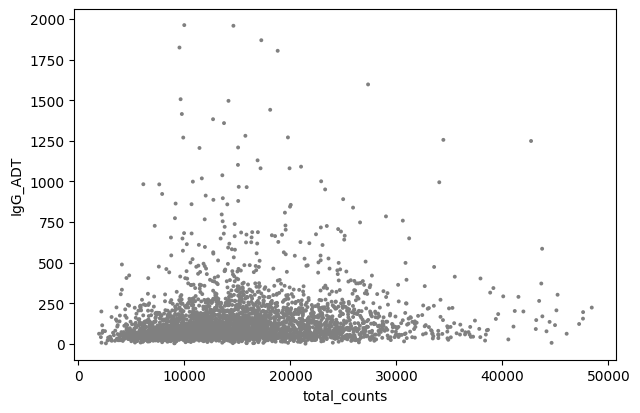

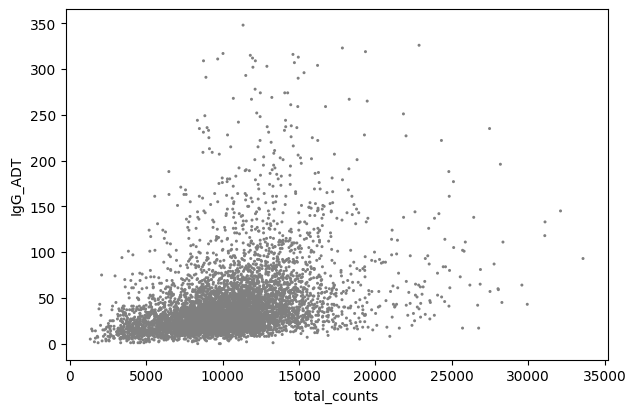

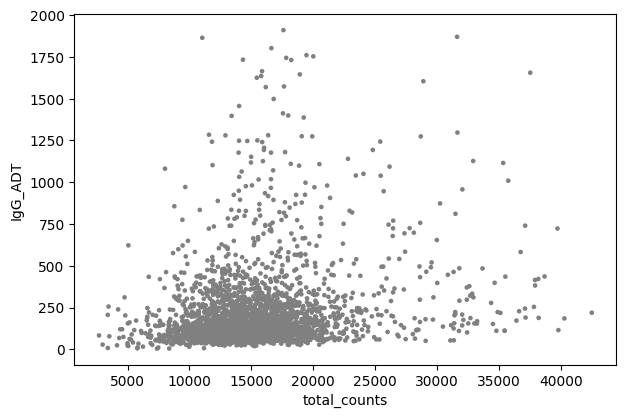

In [8]:
# Generate scatter plots for the three sample to show the relationship between total RNA counts and IgG_ADT
sc.pl.scatter(d0, x='total_counts', y='IgG_ADT')
sc.pl.scatter(d1, x='total_counts', y='IgG_ADT')
sc.pl.scatter(d2, x='total_counts', y='IgG_ADT')

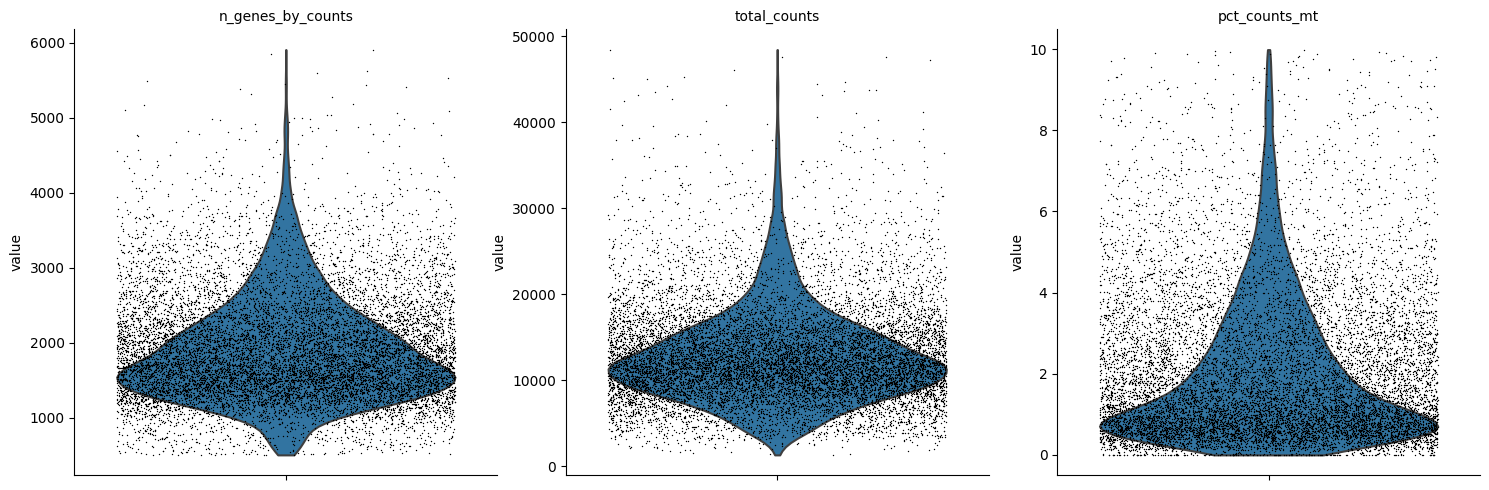

In [9]:
# Create violin plots for key quality control metrics ('n_genes_by_counts', 'total_counts', 'pct_counts_mt') across all samples
sc.pl.violin(data, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)


In [10]:
# Extract only the gene expression data from the full dataset and store it in a new variable 'rna'
rna=data[:, data.var["feature_types"] == "Gene Expression"].copy()

In [11]:
# Extract only the antibody capture data from the full dataset and store it in a new variable 'adt'
adt=data[:, data.var["feature_types"] == "Antibody Capture"].copy()

In [12]:
# Normalize the gene expression data so that the total counts for each cell sum to a constant value
sc.pp.normalize_total(rna)
# Apply logarithmic scaling to the normalized data
sc.pp.log1p(rna)

In [13]:
# Perform Principal Component Analysis (PCA) on the gene expression data for dimensionality reduction
sc.pp.pca(rna)
# Perform Batch Balanced K-Nearest Neighbors (BBKNN) to correct for batch effects in the data
sc.external.pp.bbknn(rna, batch_key='sample')

/Users/pablodigiusto/miniforge3/envs/secrecon/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/pablodigiusto/miniforge3/envs/secrecon/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


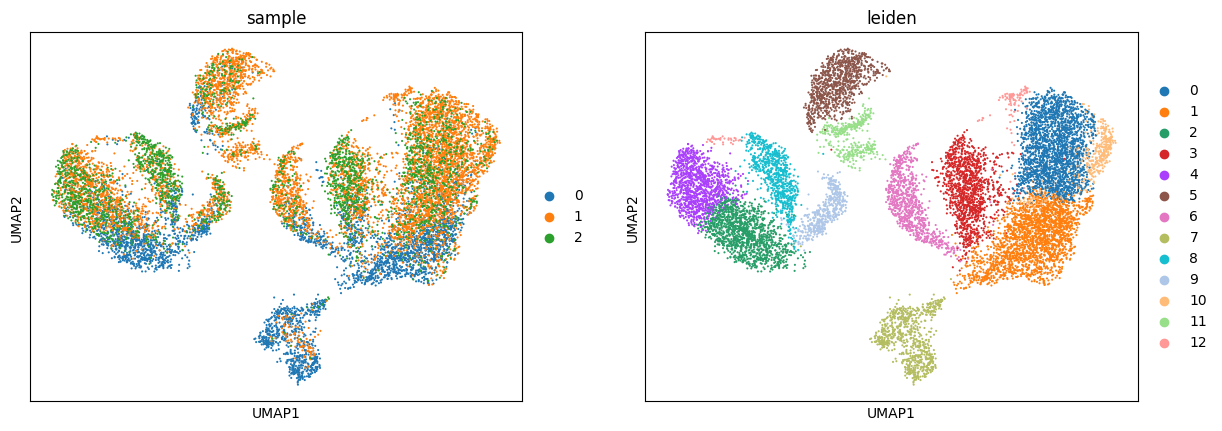

In [14]:
# Apply UMAP (Uniform Manifold Approximation and Projection) for data visualization
sc.tl.umap(rna)
# Cluster the cells using the Leiden algorithm
sc.tl.leiden(rna,resolution = 0.7)
# Visualize the UMAP plot, colored by sample origin and Leiden cluster assignments
sc.pl.umap(rna, color=['sample','leiden'])

/Users/pablodigiusto/miniforge3/envs/secrecon/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/pablodigiusto/miniforge3/envs/secrecon/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


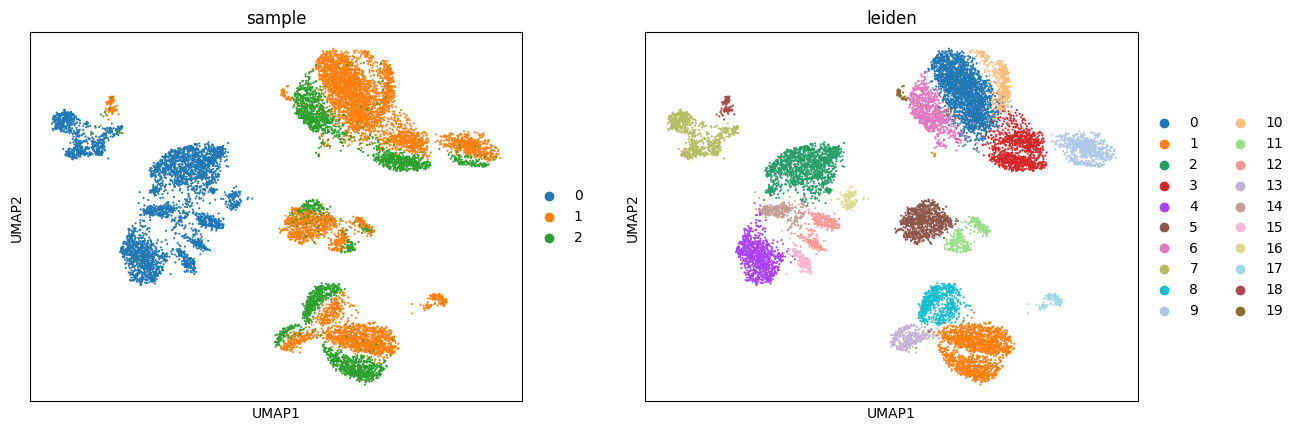

/Users/pablodigiusto/miniforge3/envs/secrecon/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/pablodigiusto/miniforge3/envs/secrecon/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


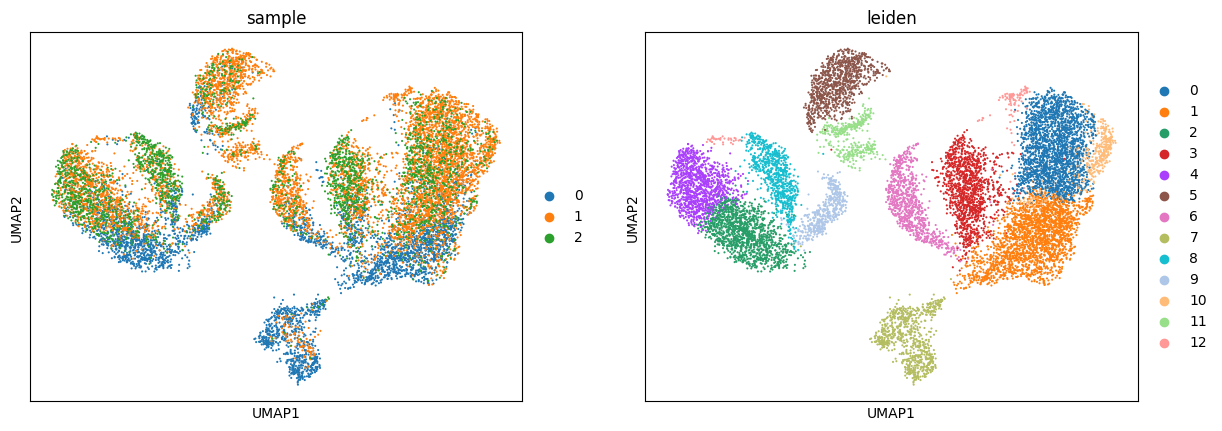

In [15]:
# Create a new AnnData object 'nb' for gene expression data, normalize, log transform, and perform PCA
nb=data[:, data.var["feature_types"] == "Gene Expression"].copy()
sc.pp.normalize_total(nb)
sc.pp.log1p(nb)
sc.pp.pca(nb)
# Find 20 nearest neighbors for each cell
sc.pp.neighbors(nb, n_neighbors=20)
# Perform UMAP for visualization and Leiden clustering
sc.tl.umap(nb)
sc.tl.leiden(nb,resolution = 0.7, key_added="leiden")
# Plot UMAP visualizations, colored by sample and Leiden cluster
sc.pl.umap(nb, color=['sample','leiden'])
sc.pl.umap(rna, color=['sample','leiden'])

/Users/pablodigiusto/miniforge3/envs/secrecon/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:368: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/pablodigiusto/miniforge3/envs/secrecon/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/pablodigiusto/miniforge3/envs/secrecon/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


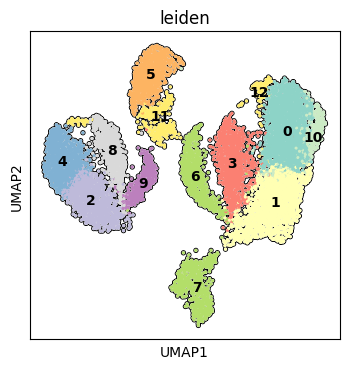

In [16]:
# Generate a UMAP plot for the 'rna' object, colored by Leiden cluster
with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(rna, color=["leiden"], size=20,alpha=1,legend_loc="on data", 
               add_outline=True,palette='Set3', show=False)
plt.savefig('leiden.pdf')

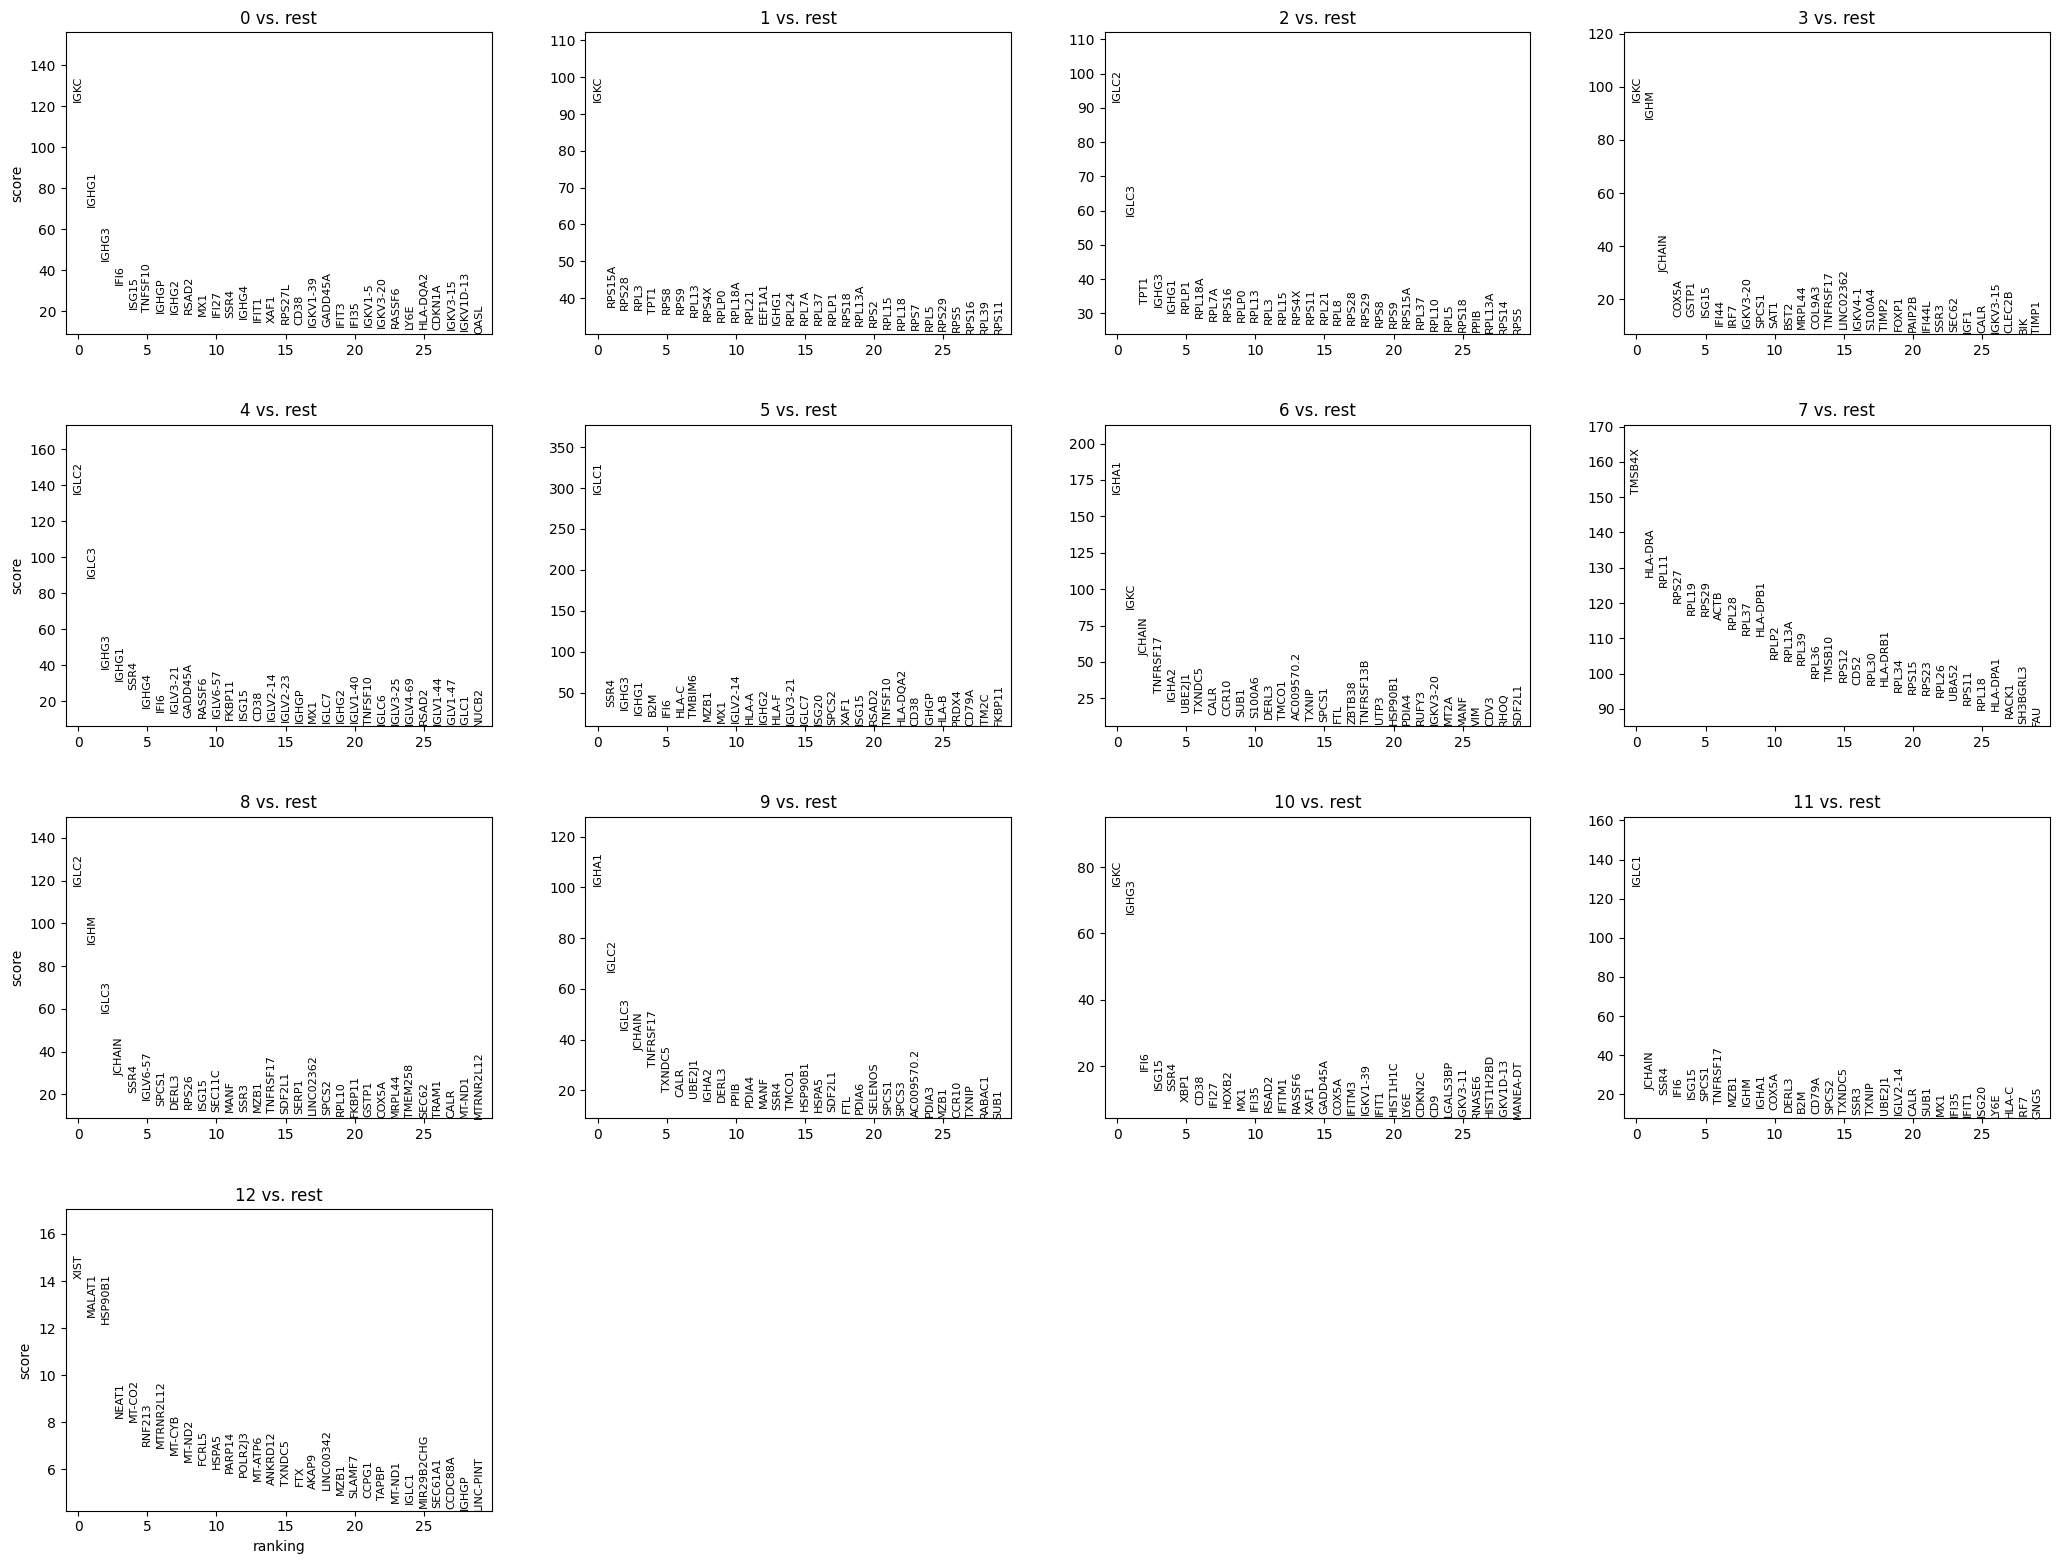

In [17]:
# Rank genes that are differentially expressed between Leiden clusters using the t-test method
rna_t=sc.tl.rank_genes_groups(rna, 'leiden', method='t-test')
# Plot the top 30 differentially expressed genes for each cluster
sc.pl.rank_genes_groups(rna, n_genes=30, sharey=False)

/Users/pablodigiusto/miniforge3/envs/secrecon/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:368: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
/Users/pablodigiusto/miniforge3/envs/secrecon/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(


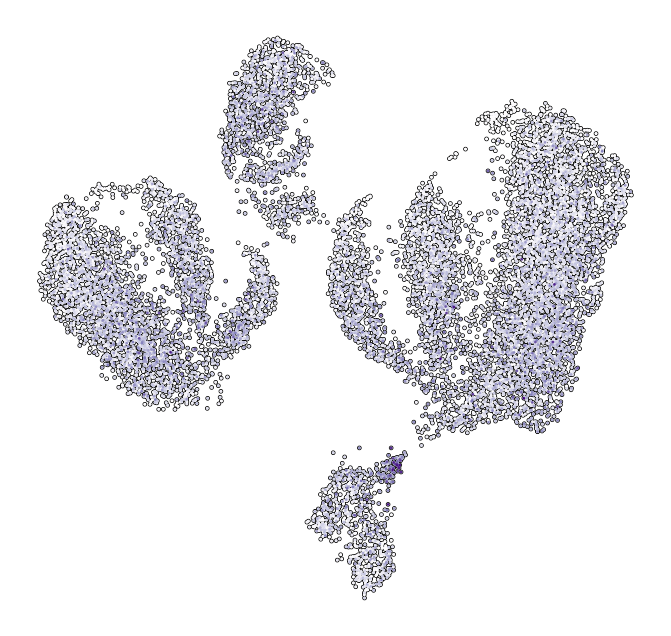

In [28]:
# Plot a UMAP visualization colored by expression levels of the gene 'MIF'
with rc_context({'figure.figsize': (8.4, 8)}):

#     ax = sc.pl.umap(rna, size=50, show=False)
    ax=sc.pl.umap(rna,color=['MIF'], legend_loc='none',size=15,show=False, alpha=1,
                    add_outline=True,frameon=False, cmap='Purples',colorbar_loc=None,vmin=1.5,
                   )
    ax.set_title('')   
plt.show()

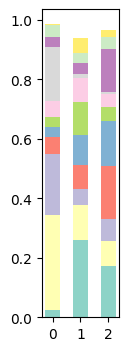

sample,0,1,2
leiden,,,
0,0.026066,0.260720,0.172697
1,0.318062,0.116014,0.085043
2,0.204055,0.053797,0.074226
3,0.059768,0.083268,0.176054
4,0.031859,0.099797,0.151436
5,0.033175,0.111960,0.047743
6,0.053449,0.078434,0.045132
7,0.184308,0.014190,0.005222
8,0.031596,0.038516,0.145468


In [21]:
# Group data by 'sample' and 'leiden' cluster, then normalize within each group to create a stacked bar plot
d=rna.obs
dd=d.groupby('sample')['leiden'].value_counts(normalize=True).unstack('sample')
# al=d['leiden'].value_counts(normalize=True)
# dd['all']= al

labels = dd.columns
c0= dd.iloc[0]
c1 =  dd.iloc[1]
c2 = dd.iloc[2]
c3 = dd.iloc[3]
c4 = dd.iloc[4]
c5 = dd.iloc[5]
c6 = dd.iloc[6]
c7 = dd.iloc[7]
c8 = dd.iloc[8]
c9 = dd.iloc[9]
c10 = dd.iloc[10]

fig = plt.figure(figsize=(1,4))
ax = fig.add_subplot(111)
width = 0.55       # the width of the bars: can also be len(x) sequence

cmap=mpl.colormaps.get_cmap("Set3").colors
ax.bar(labels, c0, width,color=cmap[0],alpha=1)
ax.bar(labels, c1, width, bottom=c0,color=cmap[1],alpha=1,)
ax.bar(labels, c2, width, bottom=c0+c1,color=cmap[2],alpha=1,)
ax.bar(labels, c3, width, bottom=c0+c1+c2,color=cmap[3],alpha=1,)
ax.bar(labels, c4, width, bottom=c0+c1+c2+c3,color=cmap[4],alpha=1,)
ax.bar(labels, c5, width, bottom=c0+c1+c2+c3+c4,color=cmap[6],alpha=1,)
ax.bar(labels, c6, width, bottom=c0+c1+c2+c3+c4+c5,color=cmap[7],alpha=1,)
ax.bar(labels, c7, width, bottom=c0+c1+c2+c3+c4+c5+c6,color=cmap[8],alpha=1,)
ax.bar(labels, c8, width, bottom=c0+c1+c2+c3+c4+c5+c6+c7,color=cmap[9],alpha=1,)
ax.bar(labels, c9, width, bottom=c0+c1+c2+c3+c4+c5+c6+c7+c8,color=cmap[10],alpha=1,)
ax.bar(labels, c10, width, bottom=c0+c1+c2+c3+c4+c5+c6+c7+c8+c9,color=cmap[11],alpha=1,)



# plt.ylim(0,1.1)

# plt.savefig('gbar.pdf')
# plt.legend(loc='upper right')
plt.show()

dd

/Users/pablodigiusto/miniforge3/envs/secrecon/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:368: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/pablodigiusto/miniforge3/envs/secrecon/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/pablodigiusto/miniforge3/envs/secrecon/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


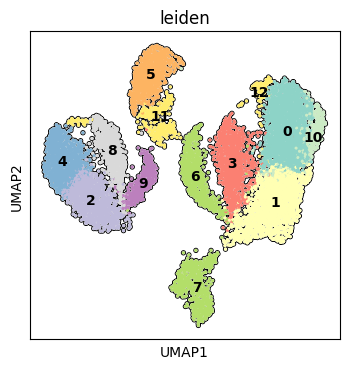

In [22]:
#Generates a UMAP plot for 'rna' object, colored by Leiden cluster
with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(rna, color=["leiden"], size=20,alpha=1,legend_loc="on data", 
               add_outline=True,palette='Set3', show=False)
#     sc.pl.umap(rna, color=['sample'], size=20,)
plt.savefig('leiden.pdf')

In [23]:
# Define categories based on Ig counts and store them as subsets of the main 'rna' AnnData object
M=rna[(rna.obs_vector('IGHM')> 4) & (rna.obs_vector('IGHA1') < 4.5)& (rna.obs_vector('IGHG1') < 4.5)]
A=rna[(rna.obs_vector('IGHA1') > 4.5)&(rna.obs_vector('IGHM')<4.6)&(rna.obs_vector('IGHG1')<3) ]
G1=rna[(rna.obs_vector('IGHG1') > 3)&(rna.obs_vector('IGHG2')<4)]
G3=rna[(rna.obs_vector('IGHG1') < 3)&(rna.obs_vector('IGHG3')>3.5)]
G2=rna[(rna.obs_vector('IGHG2') > 3.2)&(rna.obs_vector('IGHG3') <4.3)]
G4=rna[(rna.obs_vector('IGHG4') > 4)&(rna.obs_vector('IGHG3') <3.5)]

In [29]:
# Define subsets of the main 'rna' AnnData object based on IGKC and IGLC expression levels
K=rna[(rna.obs_vector('IGKC')> 6.5) & (rna.obs_vector('IGLC1') < 6)& (rna.obs_vector('IGLC2') < 6)& (rna.obs_vector('IGLC3') < 6)]
L=rna[(rna.obs_vector('IGKC')< 6.5) & ((rna.obs_vector('IGLC1') > 6)|(rna.obs_vector('IGLC2') > 6)|(rna.obs_vector('IGLC3') > 6)|(rna.obs_vector('IGLC5') > 0.25)|(rna.obs_vector('IGLC6') > 0.25)|(rna.obs_vector('IGLC7') > 6))]

In [30]:
# Initialize new columns 'Ig', 'IgL', and 'IgH' in the 'obs' DataFrame of the 'rna' object
rna.obs['Ig']='x'
rna.obs['IgL']='x'
rna.obs['IgH']='x'

In [31]:
# Assign values to 'Ig', 'IgL', and 'IgH' columns based on cell indices in subsets M, A, K, L, G1, G2, G3, and G4
m_i=M.obs.index
a_i=A.obs.index
kap_i=K.obs.index
lam_i=L.obs.index
g1_i=G1.obs.index
g2_i=G2.obs.index
g3_i=G3.obs.index
g4_i=G4.obs.index


rna.obs.loc[m_i,'Ig'] ='M'
rna.obs.loc[a_i,'Ig'] ='A'
rna.obs.loc[g1_i,'Ig'] ='G'
rna.obs.loc[g2_i,'Ig'] = 'G'
rna.obs.loc[g3_i,'Ig'] = 'G'
rna.obs.loc[g4_i,'Ig'] = 'G'


rna.obs.loc[kap_i, 'IgL'] = 'kappa'
rna.obs.loc[lam_i, 'IgL'] = 'lambda'

rna.obs.loc[m_i, 'IgH'] = 'M'
rna.obs.loc[a_i, 'IgH'] = 'A'
rna.obs.loc[g1_i, 'IgH'] = 'G1'
rna.obs.loc[g2_i, 'IgH'] = 'G2'
rna.obs.loc[g3_i, 'IgH'] = 'G3'
rna.obs.loc[g4_i, 'IgH'] = 'G4'

/Users/pablodigiusto/miniforge3/envs/secrecon/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:368: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/pablodigiusto/miniforge3/envs/secrecon/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/pablodigiusto/miniforge3/envs/secrecon/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


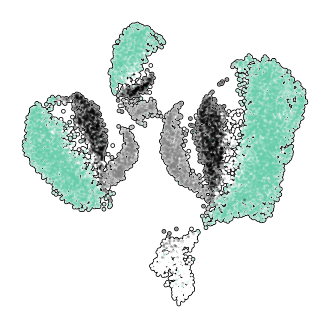

In [32]:
# Plot a UMAP visualization colored by the 'Ig' column values
with rc_context({'figure.figsize': (4, 4)}):
#     ax = sc.pl.umap(rna, size=10, add_outline=True, outline_width=(0.5, 0.05),frameon=True, show=False)
    
    ax=sc.pl.umap(rna, color=["Ig"], size=15,
               palette={'A':'grey','M':'k','G':'mediumaquamarine','x':'white'},alpha=0.4,add_outline=True,
              frameon=False,legend_loc='None', show=False)
    ax.set_title('')   
    

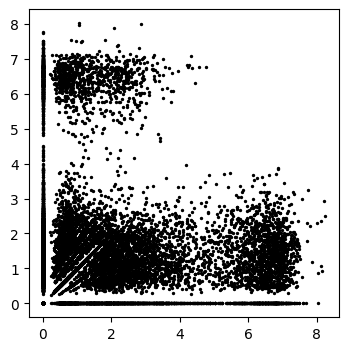

In [33]:
# Create a scatter plot for the expression levels of IGHA1 and IGHM
G=rna[rna.obs.Ig=='G']
x='IGHM'
y='IGHA1'
fig=plt.figure(figsize=(4,4))
plt.scatter(rna.obs_vector(x),rna.obs_vector(y),color='k',s=2)
# plt.scatter(M.obs_vector(x),M.obs_vector(y),color='k',s=2)
# plt.scatter(A.obs_vector(x),A.obs_vector(y),color='grey',s=2)
# plt.scatter(G.obs_vector(x),G.obs_vector(y),color='mediumaquamarine',s=2)

plt.show()
# plt.axvline(x=4.5,linewidth=1, c='k')
# plt.axhline(y=4.35,linewidth=1, c='k')

In [34]:
# Define subsets 'negA' and 'negM' based on very low expression levels of IGHA1 and IGHM
negA=rna[rna.obs_vector('IGHA1')<0.05]
negM=rna[rna.obs_vector('IGHM')<0.05]

In [35]:
negM

View of AnnData object with n_obs × n_vars = 3800 × 36691
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'sample', 'leiden', 'Ig', 'IgL', 'IgH'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'n_cells_by_counts-2', 'mean_counts-2', 'pct_dropout_by_counts-2', 'total_counts-2'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'sample_colors', 'leiden_colors', 'rank_genes_groups', 'Ig_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [36]:
# Perform log-transformation on 'datar' and assign it to the raw attribute of the 'rna' object
datar=data[data.obs.index.isin(rna.obs.index)]

sc.pp.log1p(datar)
rna.raw = datar

/Users/pablodigiusto/miniforge3/envs/secrecon/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:372: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [37]:
# Split data into two subsets based on Leiden cluster '6'
c6=rna[rna.obs.leiden=='6']
asc=rna[rna.obs.leiden!='6']

/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/ipykernel_19268/854795081.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(s0M.raw.obs_vector('IgG_ADT'), kde=True,
/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/ipykernel_19268/854795081.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = 

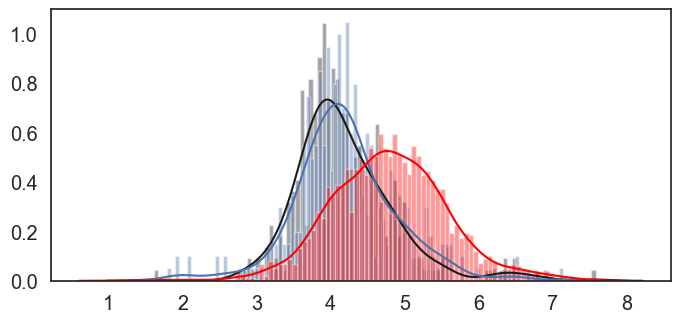

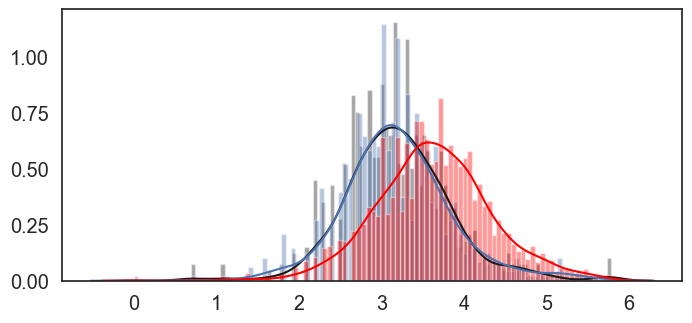

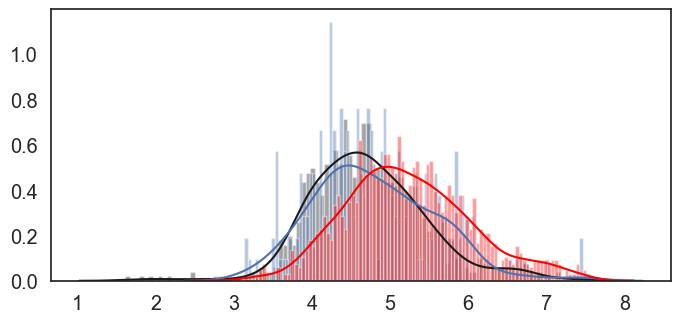

In [38]:
# Plot histograms for 'IgG_ADT' expression in subsets of samples '0', '1', and '2'
fig = plt.figure(figsize=(8,12))

ax = sns.set(font_scale=1.3) 
ax = sns.set_style("white")
# sns.kdeplot( M.obs_vector('IgG_ADT'), #kde=False,
#    color = 'slategrey',shade=True)
ax1 = fig.add_subplot(311)
s0=rna[rna.obs['sample']=='0']
s0M=s0[s0.obs.Ig=='M']
s0A=s0[s0.obs.Ig=='A']
s0G=s0[s0.obs.Ig=='G']
ax1 = sns.distplot(s0M.raw.obs_vector('IgG_ADT'), kde=True,
             color = 'k',bins=100,norm_hist=True
        )
ax1 = sns.distplot(s0A.raw.obs_vector('IgG_ADT'), kde=True,
             color = 'b',bins=100,norm_hist=True
        )
ax1 = sns.distplot(s0G.raw.obs_vector('IgG_ADT'), kde=True,
             color = 'red',bins=100,norm_hist=True
        )#,bins=int(30))
# sns.kdeplot( A.obs_vector('IgG_ADT'), #kde=False,
#              color = 'purple',shade=True)
ax1.set(xlabel=None)
ax1.set(ylabel=None)
# plt.xticks([])
# plt.yticks([])

# # plt.axvline(x=5,linewidth=1,c='purple' )
fig = plt.figure(figsize=(8,12))

ax = sns.set(font_scale=1.3) 
ax = sns.set_style("white")
# sns.kdeplot( M.obs_vector('IgG_ADT'), #kde=False,
#    color = 'slategrey',shade=True)
ax1 = fig.add_subplot(311)
s1=rna[rna.obs['sample']=='1']
s1M=s1[s1.obs.Ig=='M']
s1A=s1[s1.obs.Ig=='A']
s1G=s1[s1.obs.Ig=='G']
ax1 = sns.distplot(s1M.raw.obs_vector('IgG_ADT'), kde=True,
             color = 'k',bins=100,norm_hist=True
        )
ax1 = sns.distplot(s1A.raw.obs_vector('IgG_ADT'), kde=True,
             color = 'b',bins=100,norm_hist=True
        )
ax1 = sns.distplot(s1G.raw.obs_vector('IgG_ADT'), kde=True,
             color = 'red',bins=100,norm_hist=True
        )#,bins=int(30))
# sns.kdeplot( A.obs_vector('IgG_ADT'), #kde=False,
#              color = 'purple',shade=True)
ax1.set(xlabel=None)
ax1.set(ylabel=None)
# plt.xticks([])
# plt.yticks([])

# # plt.axvline(x=5,linewidth=1,c='purple' )


fig = plt.figure(figsize=(8,12))

ax = sns.set(font_scale=1.3) 
ax = sns.set_style("white")
# sns.kdeplot( M.obs_vector('IgG_ADT'), #kde=False,
#    color = 'slategrey',shade=True)
ax1 = fig.add_subplot(311)
s2=rna[rna.obs['sample']=='2']
s2M=s2[s2.obs.Ig=='M']
s2A=s2[s2.obs.Ig=='A']
s2G=s2[s2.obs.Ig=='G']
ax1 = sns.distplot(s2M.raw.obs_vector('IgG_ADT'), kde=True,
             color = 'k',bins=100,norm_hist=True
        )
ax1 = sns.distplot(s2A.raw.obs_vector('IgG_ADT'), kde=True,
             color = 'b',bins=100,norm_hist=True
        )
ax1 = sns.distplot(s2G.raw.obs_vector('IgG_ADT'), kde=True,
             color = 'red',bins=100,norm_hist=True
        )#,bins=int(30))
# sns.kdeplot( A.obs_vector('IgG_ADT'), #kde=False,
#              color = 'purple',shade=True)
ax1.set(xlabel=None)
ax1.set(ylabel=None)
# plt.xticks([])
# plt.yticks([])

# # plt.axvline(x=5,linewidth=1,c='purple' )


plt.show()